# Machine Reading: Advanced Topics in Word Vectors
## Part IV. Role of Bias in Word Embeddings (50 mins)

This is a 4-part series of Jupyter notebooks on the topic of word embeddings originally created for a workshop during the Digital Humanities 2018 Conference in Mexico City. Each part is comprised of a mix of theoretical explanations and fill-in-the-blanks activities of increasing difficulty.

Instructors:
- Eun Seo Jo, <a href="mailto:eunseo@stanford.edu">*eunseo@stanford.edu*</a>, Stanford University
- Javier de la Rosa, <a href="mailto:versae@stanford.edu">*versae@stanford.edu*</a>, Stanford University
- Scott Bailey, <a href="mailto:scottbailey@stanford.edu">*scottbailey@stanford.edu*</a>, Stanford University

In this unit, we will explore an application and caveat of using word embeddings -- cultural bias. Presenting methods and results from recent articles, we will show how word embeddings can carry the historical bias of the training corpora and lead an activity that shows these human-biases on vectors. We'll also address how such bias can be mitigated.

- 0:00 - 0:10 Algorithmic bias vs human bias 
- 0:10 - 0:40 [Activity 4] Identifying bias in corpora (occupations, gender, ...)
- 0:40 - 0:50 Towards unbiased embeddings; Examine “debiased” embeddings
- 0:50 - 0:60 Concluding remarks and debate

In [1]:
%%capture --no-stderr
import sys
!pip install Cython  # needed to compile fasttext
!pip install -r requirements.txt
!python -m nltk.downloader all
print("All done!", file=sys.stderr)

All done!


In [2]:
import numpy as np
import nltk
# import plotly.plotly as py
import sklearn
import matplotlib.pyplot as plt
import gensim
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import gensim.downloader as pretrained

We'll load in a pretrained model of GloVe vectors. 

In [52]:
my_model = pretrained.load('glove-wiki-gigaword-300')

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
%matplotlib inline

Here we hand-picked a list of examples that we are interested in exploring in relation to gender.

In [82]:
descriptions = ['earrings', 'physics', 'nice', 'genius', 'leader', 'dull', 'charismatic', 'whimsical', 
                'business', 'wealthy', 'weapons', 'engineer', 'hysterical']

Let's get the vectors for 'he' and 'she', and then determine similarity scores in relation to the words in our list.

In [83]:
she = my_model['she'].reshape(1,-1)
he = my_model['he'].reshape(1,-1)

for word in descriptions:
    our_vector = my_model[word].reshape(1,-1)
    print(word+"_she", cosine_similarity(our_vector, she))
    print(word+"_he", cosine_similarity(our_vector, he)) 

earrings_she [[0.1556954]]
earrings_he [[0.00201571]]
physics_she [[0.12527204]]
physics_he [[0.22394167]]
nice_she [[0.30424422]]
nice_he [[0.31524506]]
genius_she [[0.12881698]]
genius_he [[0.21715772]]
leader_she [[0.1804142]]
leader_he [[0.3512075]]
dull_she [[0.10580092]]
dull_he [[0.09116497]]
charismatic_she [[0.08711539]]
charismatic_he [[0.14945808]]
whimsical_she [[0.02358968]]
whimsical_he [[-0.04707601]]
business_she [[0.31565934]]
business_he [[0.39541444]]
wealthy_she [[0.18962963]]
wealthy_he [[0.23310974]]
weapons_she [[0.19932981]]
weapons_he [[0.27914166]]
engineer_she [[0.14359437]]
engineer_he [[0.28714356]]
hysterical_she [[0.1514557]]
hysterical_he [[0.02558503]]


We've proviously looked at analogies using vectors. Here's one that is revealing in relation to gender. 

Man : Professor :: Woman : _____.

In [109]:
my_model.most_similar_cosmul(positive=['woman','professor'], negative=['man'])

[('lecturer', 0.9340023398399353),
 ('sociology', 0.8966711759567261),
 ('emerita', 0.895513117313385),
 ('university', 0.886742353439331),
 ('psychologist', 0.877559244632721),
 ('ph.d.', 0.8717314600944519),
 ('graduate', 0.8693352341651917),
 ('adjunct', 0.8692690134048462),
 ('researcher', 0.8651377558708191),
 ('sociologist', 0.8630502223968506)]

Here is another example: Mark : Doctor :: Karim : ______.

In [114]:
my_model.most_similar_cosmul(positive=['karim','doctor'], negative=['mark'])

[('pharmacist', 0.9476046562194824),
 ('abdel', 0.9220354557037354),
 ('haidar', 0.919265627861023),
 ('abdul', 0.9009649753570557),
 ('kader', 0.8989163637161255),
 ('wae', 0.897967517375946),
 ('sadiq', 0.8867441415786743),
 ('abdulla', 0.864159107208252),
 ('physician', 0.8627878427505493),
 ('abdus', 0.8626350164413452)]

What do you think of these differences between the two gender pronouns?

While as humanists and social scientists we might find such discrepancies, or rather consistent biases, interesting data, computer scientists found this embedded bias deeply problematic (and perhaps horrifying). So, they have tried to correct these discrepancies.

Here's another analogy example: He : Liar :: She : ____.

In [134]:
my_model.most_similar_cosmul(positive=['she','liar'], negative=['he'])

[('whore', 0.7929101586341858),
 ('liars', 0.7914846539497375),
 ('himeko', 0.7882606387138367),
 ('bitch', 0.7868947386741638),
 ('seductress', 0.7857852578163147),
 ('bare-breasted', 0.7846784591674805),
 ('adulteress', 0.7810280323028564),
 ('courtesan', 0.7761551737785339),
 ('enounters', 0.7743799090385437),
 ('gringa', 0.7739593386650085)]

First we will work through examples from a paper that came out in 2016 on debiasing gender vectors by Bolukbasi, et al. 2016. (https://arxiv.org/pdf/1607.06520.pdf)

Here the authors propose a  linear algebraic method of neutralizing vectors such that they no longer contain gendered connotations. They claim that their algorithms guarantee: 

1. gender neutral words (such as babysit) will be equidistant to definitional gender words (such as mom and dad).
2. maintain the functional non-gender-related words' assocations with gender neutral words and maintain definitional gender associations for words such as father and mister.

In the rest of this unit, we'll go through the paper together.


The paper introduces two main forms of bias:
1. direct bias: The obvious form of bias where the man vector may be closer to professor than is a vector for woman. This refers to bias measured by the cosine similarity between a vector of gender neutral term and the gender direction.


2. indirect bias: This refers to the bias of gender neutral terms that are closer or farther to terms that may carry certain indirect gender implications. For instance, the word receptionist may be closer to softball than is to football. The authors propose a method to measure this. They measure the change in the inner product of two vectors before and after the gender component has been subtracted out.

In [84]:
import json
import random
import numpy as np

import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding
from debiaswe.data import load_professions
import numpy.linalg as la

In [85]:
from sklearn.metrics.pairwise import cosine_similarity

We first load our embedddings with the code the authors provide

In [86]:
E = WordEmbedding('./embeddings/w2v_gnews_small.txt')

*** Reading data from ./embeddings/w2v_gnews_small.txt
(26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine


The authors also give us a hand-picked set of definitional gender pairs, pairs of gender words we want to equalize, and words that are gender-specific

In [89]:
with open('./data/definitional_pairs.json', "r") as f:
    defs = json.load(f)

with open('./data/equalize_pairs.json', "r") as f:
    equalize_pairs = json.load(f)

with open('./data/gender_specific_seed.json', "r") as f:
    gender_specific_words = json.load(f)

These are definitional pairs--pairs of words that have a gender component in their definition.

This set is used for identifying the gender subspace.

In [135]:
defs

[['woman', 'man'],
 ['girl', 'boy'],
 ['she', 'he'],
 ['mother', 'father'],
 ['daughter', 'son'],
 ['gal', 'guy'],
 ['female', 'male'],
 ['her', 'his'],
 ['herself', 'himself'],
 ['Mary', 'John']]

This is our equality set. We'll iterate through this list to neutralize.

In [136]:
equalize_pairs

[['monastery', 'convent'],
 ['spokesman', 'spokeswoman'],
 ['Catholic_priest', 'nun'],
 ['Dad', 'Mom'],
 ['Men', 'Women'],
 ['councilman', 'councilwoman'],
 ['grandpa', 'grandma'],
 ['grandsons', 'granddaughters'],
 ['prostate_cancer', 'ovarian_cancer'],
 ['testosterone', 'estrogen'],
 ['uncle', 'aunt'],
 ['wives', 'husbands'],
 ['Father', 'Mother'],
 ['Grandpa', 'Grandma'],
 ['He', 'She'],
 ['boy', 'girl'],
 ['boys', 'girls'],
 ['brother', 'sister'],
 ['brothers', 'sisters'],
 ['businessman', 'businesswoman'],
 ['chairman', 'chairwoman'],
 ['colt', 'filly'],
 ['congressman', 'congresswoman'],
 ['dad', 'mom'],
 ['dads', 'moms'],
 ['dudes', 'gals'],
 ['ex_girlfriend', 'ex_boyfriend'],
 ['father', 'mother'],
 ['fatherhood', 'motherhood'],
 ['fathers', 'mothers'],
 ['fella', 'granny'],
 ['fraternity', 'sorority'],
 ['gelding', 'mare'],
 ['gentleman', 'lady'],
 ['gentlemen', 'ladies'],
 ['grandfather', 'grandmother'],
 ['grandson', 'granddaughter'],
 ['he', 'she'],
 ['himself', 'herself'],

This is the base set of gender specific words

For our set of gender neutral words we take the complement of this from vocab set.

The authors trained a linear classifier (SVM) to automatically find a list of gender specific words from a vocabulary of 3 million.

In [138]:
gender_specific_words

['actress',
 'actresses',
 'aunt',
 'aunts',
 'bachelor',
 'ballerina',
 'barbershop',
 'baritone',
 'beard',
 'beards',
 'beau',
 'bloke',
 'blokes',
 'boy',
 'boyfriend',
 'boyfriends',
 'boyhood',
 'boys',
 'brethren',
 'bride',
 'brides',
 'brother',
 'brotherhood',
 'brothers',
 'bull',
 'bulls',
 'businessman',
 'businessmen',
 'businesswoman',
 'chairman',
 'chairwoman',
 'chap',
 'colt',
 'colts',
 'congressman',
 'congresswoman',
 'convent',
 'councilman',
 'councilmen',
 'councilwoman',
 'countryman',
 'countrymen',
 'czar',
 'dad',
 'daddy',
 'dads',
 'daughter',
 'daughters',
 'deer',
 'diva',
 'dowry',
 'dude',
 'dudes',
 'elder_brother',
 'eldest_son',
 'estranged_husband',
 'estranged_wife',
 'estrogen',
 'ex_boyfriend',
 'ex_girlfriend',
 'father',
 'fathered',
 'fatherhood',
 'fathers',
 'fella',
 'fellas',
 'female',
 'females',
 'feminism',
 'fiance',
 'fiancee',
 'fillies',
 'filly',
 'fraternal',
 'fraternities',
 'fraternity',
 'gal',
 'gals',
 'gelding',
 'gentle

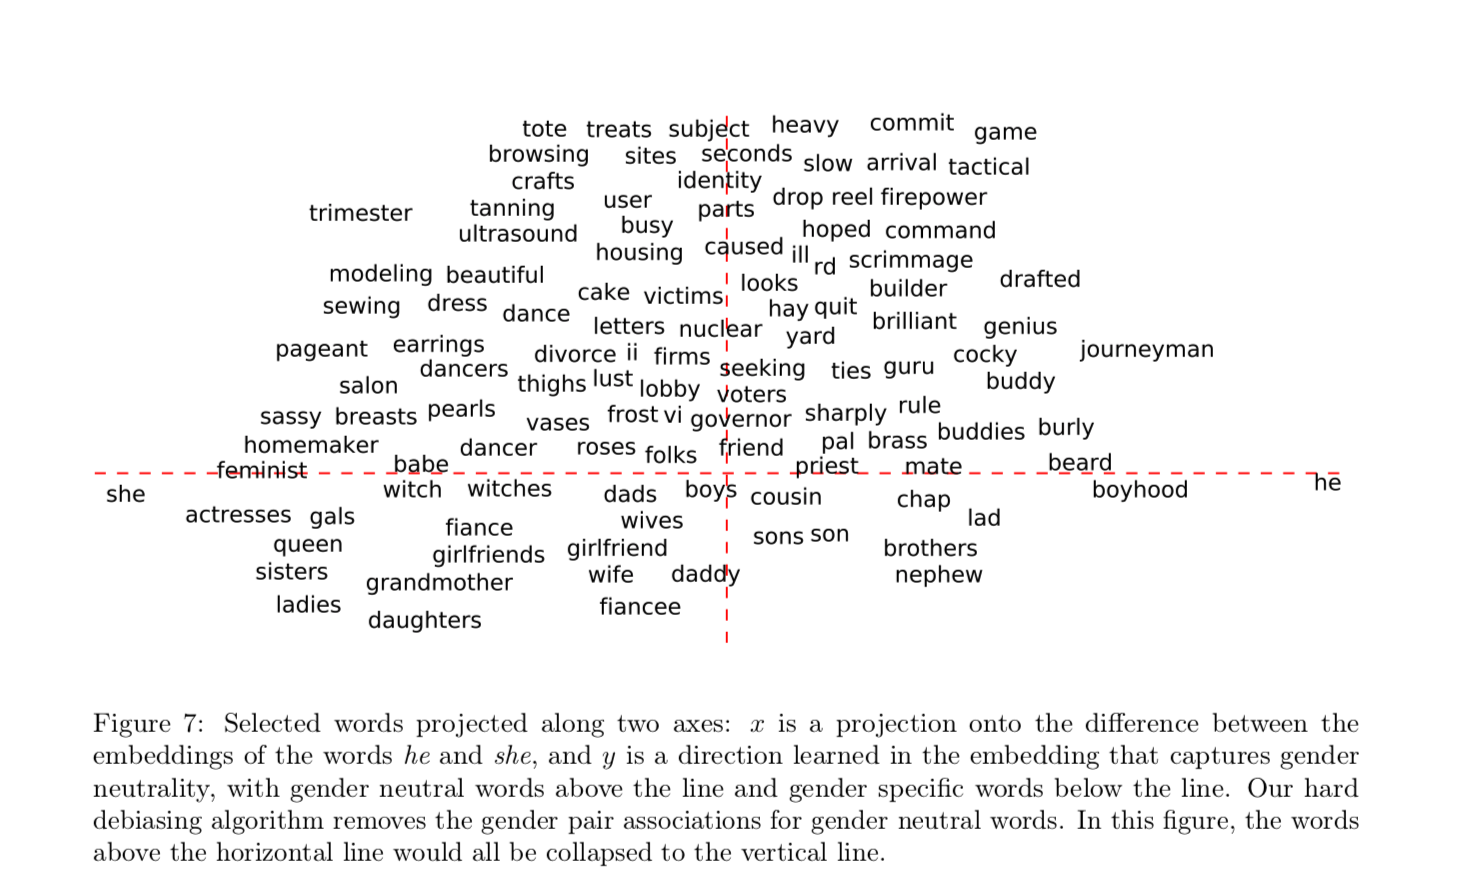

In [220]:
from IPython.display import Image
'Image source: pg.11, Bolukbasi, et al. 2016. (https://arxiv.org/pdf/1607.06520.pdf)'
Image("./part4.png")

Let's load in a list of professions. 

In [139]:
professions = load_professions()

Loaded professions
Format:
word,
definitional female -1.0 -> definitional male 1.0
stereotypical female -1.0 -> stereotypical male 1.0


In [140]:
professions #this list was generated via human surveys

[['accountant', 0.0, 0.4],
 ['acquaintance', 0.0, 0.0],
 ['actor', 0.8, 0.0],
 ['actress', -1.0, 0.0],
 ['adjunct_professor', 0.0, 0.5],
 ['administrator', 0.0, 0.2],
 ['adventurer', 0.0, 0.5],
 ['advocate', 0.0, -0.1],
 ['aide', 0.0, -0.2],
 ['alderman', 0.7, 0.2],
 ['alter_ego', 0.0, 0.0],
 ['ambassador', 0.0, 0.7],
 ['analyst', 0.0, 0.4],
 ['anthropologist', 0.0, 0.4],
 ['archaeologist', 0.0, 0.6],
 ['archbishop', 0.4, 0.5],
 ['architect', 0.1, 0.6],
 ['artist', 0.0, -0.2],
 ['artiste', -0.1, -0.2],
 ['assassin', 0.1, 0.8],
 ['assistant_professor', 0.1, 0.4],
 ['associate_dean', 0.0, 0.4],
 ['associate_professor', 0.0, 0.4],
 ['astronaut', 0.1, 0.8],
 ['astronomer', 0.1, 0.5],
 ['athlete', 0.0, 0.7],
 ['athletic_director', 0.1, 0.7],
 ['attorney', 0.0, 0.3],
 ['author', 0.0, 0.1],
 ['baker', 0.0, -0.1],
 ['ballerina', -0.5, -0.5],
 ['ballplayer', 0.2, 0.8],
 ['banker', 0.0, 0.6],
 ['barber', 0.5, 0.5],
 ['baron', 0.6, 0.3],
 ['barrister', 0.1, 0.4],
 ['bartender', 0.0, 0.3],
 ['biol

What is the problem we're dealing with here? Where is the 'bias'?

As a simple example we identify a gender subspace or direction by subtracting the 'he' vector from the 'she' vector

In [157]:
gender_vector = we.doPCA(defs, E).components_[0]

Using cosine similarity, see how gender specific words (such as 'boyfriend' or 'actress') relate to the gender vector

In [158]:
for w in gender_specific_words:
    if w in E.index:
        print (w, cosine_similarity(E.v(w).reshape(1,-1), gender_vector.reshape(1,-1)))

actress [[0.37881422]]
actresses [[0.37773782]]
aunt [[0.22735584]]
aunts [[0.22387406]]
bachelor [[0.02035015]]
ballerina [[0.2606187]]
barbershop [[-0.06264466]]
baritone [[-0.14292906]]
beard [[-0.2891144]]
beards [[-0.14897317]]
beau [[0.16766915]]
bloke [[-0.18723752]]
blokes [[-0.0378492]]
boy [[-0.08261273]]
boyfriend [[0.19008808]]
boyfriends [[0.29124805]]
boyhood [[-0.32075408]]
boys [[-0.01961494]]
brethren [[-0.15321788]]
bride [[0.22300948]]
brides [[0.32298708]]
brother [[-0.2159749]]
brotherhood [[-0.14518175]]
brothers [[-0.19910909]]
bull [[-0.05149252]]
bulls [[0.03535476]]
businessman [[-0.2185442]]
businessmen [[-0.12455031]]
businesswoman [[0.37963697]]
chairman [[-0.1821561]]
chairwoman [[0.38882527]]
chap [[-0.16081701]]
colt [[0.03893903]]
colts [[0.04437414]]
congressman [[-0.07359241]]
congresswoman [[0.26027215]]
convent [[0.2648416]]
councilman [[-0.09889562]]
councilmen [[-0.03343292]]
councilwoman [[0.3271047]]
countryman [[-0.32445452]]
countrymen [[-0.19

### Activity: Make your own list of words that you think will demonstrate or embed bias.


We will look at how these 'biases' are reflected in our hand-picked set of profession-related words.

In [160]:
for w in [p[0] for p in professions]:
    if w in E.index:
        print (w, cosine_similarity(E.v(w).reshape(1,-1), gender_vector.reshape(1,-1)))

accountant [[0.00842165]]
acquaintance [[-0.03130668]]
actor [[-0.08913895]]
actress [[0.37881422]]
adjunct_professor [[-0.00193109]]
administrator [[0.08757389]]
adventurer [[-0.05962051]]
advocate [[0.06923211]]
aide [[-0.00241048]]
alderman [[-0.00422638]]
alter_ego [[-0.05069161]]
ambassador [[-0.00594036]]
analyst [[-0.03249325]]
anthropologist [[0.08962004]]
archaeologist [[0.01849806]]
archbishop [[-0.01346654]]
architect [[-0.17738312]]
artist [[0.06292884]]
artiste [[0.11399285]]
assassin [[-0.09559863]]
assistant_professor [[0.0933466]]
associate_dean [[0.06798565]]
associate_professor [[0.06872162]]
astronaut [[0.05988744]]
astronomer [[-0.05478921]]
athlete [[-0.03127931]]
athletic_director [[-0.00586271]]
attorney [[0.00931382]]
author [[0.0538241]]
baker [[0.06306806]]
ballerina [[0.2606187]]
ballplayer [[-0.1173764]]
banker [[-0.06017698]]
barber [[-0.14012833]]
baron [[-0.11302587]]
barrister [[-0.01259318]]
bartender [[0.05402037]]
biologist [[0.00351001]]
bishop [[0.0

We will see now how neutralizing direct bias can change similarity results.

In [169]:
E.v('physicist')

array([ 0.0123079 ,  0.00184618,  0.159561  ,  0.0151482 , -0.0153375 ,
        0.138353  , -0.00100199, -0.0888693 ,  0.0355982 , -0.0643798 ,
        0.0097832 , -0.0676619 , -0.0304226 , -0.0355982 , -0.108057  ,
        0.0989681 ,  0.045697  ,  0.04191   ,  0.0598353 , -0.0416575 ,
       -0.0552909 ,  0.0517563 , -0.0388803 , -0.0472118 ,  0.0227223 ,
       -0.00984632, -0.0229747 , -0.0436773 , -0.0994731 , -0.0873545 ,
       -0.0393853 , -0.0401427 , -0.0316849 ,  0.0124973 ,  0.0651372 ,
        0.00735318,  0.00965697,  0.0578156 ,  0.0054281 ,  0.0487267 ,
       -0.0214599 ,  0.00046944,  0.0383754 ,  0.0878595 ,  0.00839462,
       -0.0823051 , -0.0165368 , -0.00735318,  0.00216177, -0.0823051 ,
       -0.083315  ,  0.0363556 ,  0.00105722, -0.0656421 , -0.0363556 ,
       -0.0527662 ,  0.0525137 , -0.0848298 , -0.0383754 , -0.17067   ,
       -0.00416575, -0.0228485 , -0.010225  ,  0.0633699 ,  0.074731  ,
        0.0497365 ,  0.00119923,  0.120681  ,  0.0335785 , -0.02

As a simple example we will neutralize 'physicist' so that it becomes a zero on the gender subspace.
We do this by projecting the 'physicists' vector onto the gender vector and subtracting it from the origin vector.

$$w_g = (w \cdot g)*g$$
$$w_{\bot} = w - w_g$$

bias_comp = $w_g$;
debaised_physicist: $w_{\bot}$



In [172]:
normed_physicist = E.v('physicist')/la.norm(E.v('physicist'))
factor = np.dot(normed_physicist,gender_vector.T)
bias_comp = np.multiply(gender_vector, factor)
debiased_physicist = physicist - bias_comp

Before we debiase, let's check the relation between physicist and gender. 

In [173]:
cosine_similarity(physicist.reshape(1,-1), gender_vector.reshape(1,-1))

array([[-0.09178338]], dtype=float32)

And after it's debiased, it's nearly zero. 

In [175]:
cosine_similarity(debiased.reshape(1,-1), gender_vector.reshape(1,-1))

array([[-5.9604645e-08]], dtype=float32)

In [191]:
before_debiasing =sorted([(w[0],cosine_similarity(E.v(w[0]).reshape(1,-1),gender_vector.reshape(1,-1))) for w in professions],key=lambda x:x[1][0])

Let's look at the least 'feminine' jobs.

In [192]:
before_debiasing[:15]

[('maestro', array([[-0.24443056]], dtype=float32)),
 ('protege', array([[-0.23629352]], dtype=float32)),
 ('statesman', array([[-0.22225757]], dtype=float32)),
 ('businessman', array([[-0.2185442]], dtype=float32)),
 ('sportsman', array([[-0.20920417]], dtype=float32)),
 ('philosopher', array([[-0.19628258]], dtype=float32)),
 ('marksman', array([[-0.19206828]], dtype=float32)),
 ('skipper', array([[-0.18730086]], dtype=float32)),
 ('financier', array([[-0.18292531]], dtype=float32)),
 ('architect', array([[-0.17738312]], dtype=float32)),
 ('magician', array([[-0.1720435]], dtype=float32)),
 ('trumpeter', array([[-0.17180184]], dtype=float32)),
 ('major_leaguer', array([[-0.1601317]], dtype=float32)),
 ('salesman', array([[-0.1571134]], dtype=float32)),
 ('captain', array([[-0.15365833]], dtype=float32))]

And the most feminine.

In [193]:
before_debiasing[-15:]

[('paralegal', array([[0.23194472]], dtype=float32)),
 ('nanny', array([[0.23257735]], dtype=float32)),
 ('ballerina', array([[0.2606187]], dtype=float32)),
 ('nun', array([[0.26477978]], dtype=float32)),
 ('maid', array([[0.27208695]], dtype=float32)),
 ('librarian', array([[0.27711064]], dtype=float32)),
 ('socialite', array([[0.2784637]], dtype=float32)),
 ('receptionist', array([[0.27997684]], dtype=float32)),
 ('waitress', array([[0.29655957]], dtype=float32)),
 ('registered_nurse', array([[0.3023775]], dtype=float32)),
 ('nurse', array([[0.30765718]], dtype=float32)),
 ('homemaker', array([[0.32325166]], dtype=float32)),
 ('housewife', array([[0.378435]], dtype=float32)),
 ('actress', array([[0.37881422]], dtype=float32)),
 ('businesswoman', array([[0.37963697]], dtype=float32))]

In [194]:
from debiaswe.debias import debias

The authors apply a two step de-biasing algorithm. We will just use the code they provided along with the paper.



1. identify a gender subspace: find the subspace that carries the meaning of gender bias. The authors take the first dimension of the SVD of the sum of all gender biases as the gender subspace. They show that the first dimension represents the majority of the variance. 

2. 'neutralize' and 'equalize' vectors: neutralize gender neutral words to be 0 along the gender direction (identified above); equalize all words in the equality set to be equidistant to neutral words. 


In [195]:
debias(E, gender_specific_words, defs, equalize_pairs)

26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
{('Dudes', 'Gals'), ('EX_GIRLFRIEND', 'EX_BOYFRIEND'), ('MAN', 'WOMAN'), ('Catholic_Priest', 'Nun'), ('DUDES', 'GALS'), ('CONGRESSMAN', 'CONGRESSWOMAN'), ('gentlemen', 'ladies'), ('nephew', 'niece'), ('Gelding', 'Mare'), ('men', 'women'), ('Son', 'Daughter'), ('Boys', 'Girls'), ('brother', 'sister'), ('Gentleman', 'Lady'), ('Twin_Brother', 'Twin_Sister'), ('WIVES', 'HUSBANDS'), ('GRANDFATHER', 'GRANDMOTHER'), ('Testosterone', 'Estrogen'), ('GRANDSONS', 'GRANDDAUGHTERS'), ('businessman', 'businesswoman'), ('councilman', 'councilwoman'), ('MEN', 'WOMEN'), ('BUSINESSMAN', 'BUSINESSWOMAN'), ('TESTOSTERONE', 'ESTROGEN'), ('ex_girlfriend', 'ex_boyfriend'), ('GENTLEMAN', 'LADY'), ('Nephew', 'Niece'), ('Brother', 'Sister'), ('Grandfather', 'Grandmother'), ('Congressman', 'Congresswoman'), ('colt', 'filly'), ('FRATERNITY', 'SORORITY'), ('MALES', 'FEMALES'), ('TWIN_BROTHER', 'TWIN_SISTER'), ('SONS', 'DAUGHTERS'), (

In [198]:
after_debiasing = sorted([(w[0],cosine_similarity(E.v(w[0]).reshape(1,-1),gender_vector.reshape(1,-1))) for w in professions], key=lambda x:x[1][[0]])

Now that we've debiased, let's look at the least 'feminine' jobs again.

In [199]:
after_debiasing[:15]

[('businessman', array([[-0.43325216]], dtype=float32)),
 ('congressman', array([[-0.42799944]], dtype=float32)),
 ('dad', array([[-0.36525285]], dtype=float32)),
 ('councilman', array([[-0.35791722]], dtype=float32)),
 ('statesman', array([[-0.22225757]], dtype=float32)),
 ('salesman', array([[-0.1571134]], dtype=float32)),
 ('handyman', array([[-0.10675368]], dtype=float32)),
 ('monk', array([[-0.08172014]], dtype=float32)),
 ('wrestler', array([[-4.0978193e-08]], dtype=float32)),
 ('industrialist', array([[-3.259629e-08]], dtype=float32)),
 ('pediatrician', array([[-2.9336661e-08]], dtype=float32)),
 ('magician', array([[-2.7939677e-08]], dtype=float32)),
 ('architect', array([[-2.6077032e-08]], dtype=float32)),
 ('graphic_designer', array([[-2.6077032e-08]], dtype=float32)),
 ('freelance_writer', array([[-2.0489097e-08]], dtype=float32))]

And the most.

In [200]:
after_debiasing[-15:]

[('major_leaguer', array([[2.9802322e-08]], dtype=float32)),
 ('environmentalist', array([[3.0733645e-08]], dtype=float32)),
 ('paralegal', array([[3.0733645e-08]], dtype=float32)),
 ('protege', array([[3.3527613e-08]], dtype=float32)),
 ('nurse', array([[3.7252903e-08]], dtype=float32)),
 ('pathologist', array([[4.284084e-08]], dtype=float32)),
 ('warrior', array([[4.8428774e-08]], dtype=float32)),
 ('socialite', array([[5.2154064e-08]], dtype=float32)),
 ('ballerina', array([[0.26061872]], dtype=float32)),
 ('nun', array([[0.2647798]], dtype=float32)),
 ('maid', array([[0.27208695]], dtype=float32)),
 ('waitress', array([[0.29655957]], dtype=float32)),
 ('housewife', array([[0.37843493]], dtype=float32)),
 ('actress', array([[0.37881422]], dtype=float32)),
 ('businesswoman', array([[0.4332522]], dtype=float32))]

What are you observations? What words do you notice having appeared or disappeared?